# Construindo um modelo CNN com PyTorch usando o dataset CIFAR-10 e Transfer Leraning

Veja informações sobre o dataset: https://www.cs.toronto.edu/~kriz/cifar.html

## O que é "Transfer Learning"?
Transfer Learning ou Aprendizado por Transferência, é uma técninca na qual um modelo treinado em uma tarefa (geralmente complexa e com muitos dados) é reutilizado como ponto de partida para uma nova tarefa relacionada.

Ela é utilizado quando não se tem muitos dados para treinar um modelo do zero.

Funcionamento:
Um modelo é treinado em uma grande base de dados (por exemplo, ImageNet com milhões de imagens).

Esse modelo aprende representações gerais (por exemplo, detecção de bordas, formas, padrões).

Você reaproveita esse modelo e ajusta (fine-tune) as últimas camadas com seus dados específicos.

## O que é "CNN"?

Convolutional Neural Network (CNN) é um tipo de rede neural especializada em processar dados com estrutura de grade, como imagens.

Por que usar CNN para imagens:
Imagens têm estrutura espacial (linhas e colunas de pixels). CNNs exploram isso com camadas convolucionais que detectam padrões locais (como bordas, texturas) e reduzem parâmetros em comparação a redes neurais totalmente conectadas.

Uma CNN é composta de quatro tipos básicos de camadas:

• Convolução

• Camanda de não linearidade (RELU)

• Pooling (Agregação)

• Classificação (Fully Connected)


# As quatro camadas da CNN

### 1. Camada de Convolução
Aplica filtros (kernels) à imagem de entrada para detectar características locais como bordas, cantos, texturas.

Gera mapas de ativação (feature maps) que representam onde os padrões foram encontrados.

### 2. Camada de Não Linearidade (ReLU)
Aplica uma função de ativação, geralmente ReLU (Rectified Linear Unit).

Introduz não-linearidade, permitindo que a rede aprenda padrões complexos e não apenas combinações lineares.

* Fórmula do ReLU:
\begin{equation}
f(x) = \max(0, x)
\end{equation}


### 3. Camada de Pooling (Agregação)
Reduz a dimensionalidade dos mapas de ativação mantendo as características mais importantes.

Tipos comuns: MaxPooling (pega o maior valor), AveragePooling (média).

Ajuda a reduzir o custo computacional e melhora a invariância a pequenas variações.

### 4. Camada de Classificação (Fully Connected)
Flatten: transforma os mapas finais em um vetor.

Uma ou mais camadas densas (fully connected) conectam todos os neurônios anteriores.

A última camada geralmente usa softmax (para classificação multiclasse) ou sigmoid (para binária).

## Tensor

Além disso, iremos transformar as imagens em Tensores!


Um tensor é uma estrutura de dados fundamental no machine learning e deep learning. É uma generalização de matrizes para mais dimensões.

Você pode pensar em um tensor como:



| Tipo            | Nome      | Exemplo                                 |
| --------------- | --------- | --------------------------------------- |
| Escalar         | Tensor 0D | `5`, `-3.14`                            |
| Vetor           | Tensor 1D | `[1, 2, 3]`                             |
| Matriz          | Tensor 2D | `[[1, 2], [3, 4]]`                      |
| Imagem RGB      | Tensor 3D | `3 x 32 x 32` (canal, altura, largura)  |
| Lote de imagens | Tensor 4D | `64 x 3 x 32 x 32` (batch, canal, H, W) |


São ideais para representar dados em múltiplas dimensões, como imagens, vídeos, textos, séries temporais, etc.

Permitem operações vetoriais rápidas e paralelas em GPU.

## Para Saber Mais!

Veja alguns sites de exemplos e explicações de CNN!

[2D Visualization](https://adamharley.com/nn_vis/cnn/2d.html)

[CNN Explainer](https://poloclub.github.io/cnn-explainer/)

# Criando Modelos

Vamos criar alguns modelos, com e sem Transfer Learning.

In [1]:
# Importe as bibliotecas
import torch
import torchvision
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
try:
    from torchinfo import summary
except:
    print("torchinfo não encontrado. Instalando.")
    !pip install -q torchinfo
    from torchinfo import summary

In [2]:
# No ambiente de execução, altere para uma GPU, se não estiver disponível,
# iremos utilizar o CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Verificando a GPU
!nvidia-smi

Mon May  5 16:10:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# Dividindo a base em teste e treino
# Vamos também mudar o tamanho da imagem para 32x32 e
# fazer algumas transformações para adicionar variabilidade
# Por fim transformamos a imagem em Tensores! (ToTensor())

train_data = CIFAR10(root="data",
                     download=True,
                     train=True,
                     transform=transforms.Compose([
                          transforms.Resize((32, 32)),
                          transforms.RandomPerspective(p=0.2),
                          transforms.RandomInvert(p=0.2),
                          transforms.RandomRotation(degrees=(0, 70)),
                          transforms.ToTensor()]))

test_data = CIFAR10(root="data",
                    download=True,
                    train=False,
                    transform=transforms.Compose([
                        transforms.Resize((32, 32)),
                        transforms.ToTensor()]))


In [5]:
# Verificando o tamanho
len(train_data), len(test_data)

(50000, 10000)

In [6]:
# Verificando a primeira imagem
image, label = train_data[0]
image, label

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 6)

In [7]:
# Veja o formato da imagem
# o formato é [3, 32, 32] (canais de cores, altura, largura)
image.shape

torch.Size([3, 32, 32])

In [8]:
# Veja as classes
class_names = train_data.classes
class_names, len(class_names)

(['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 10)

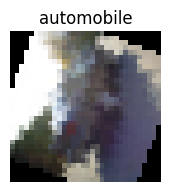

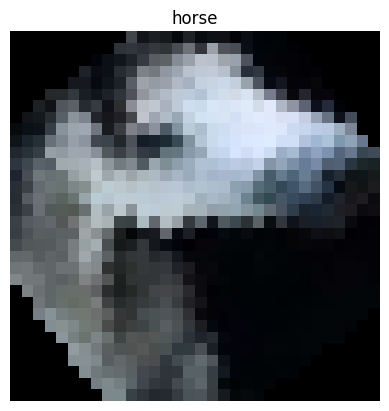

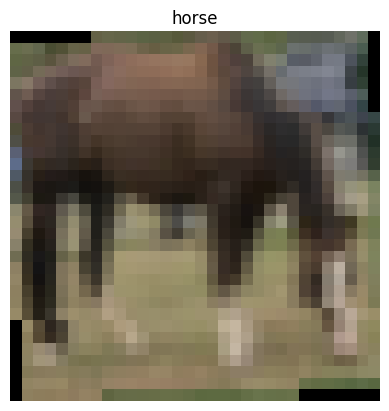

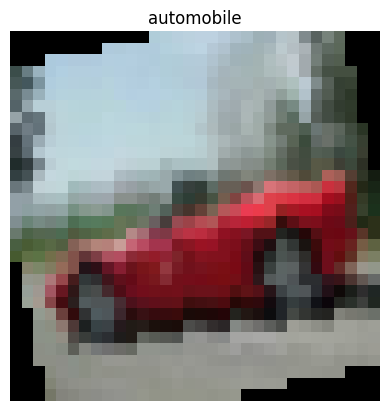

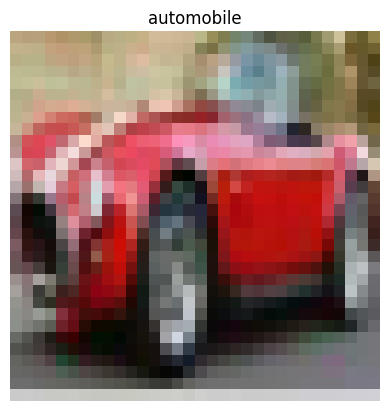

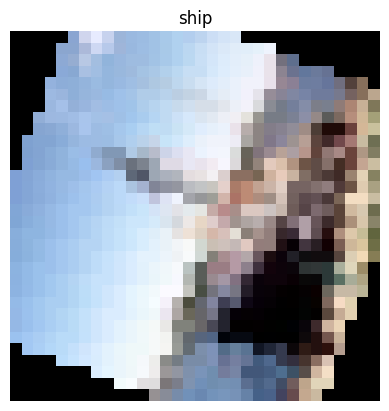

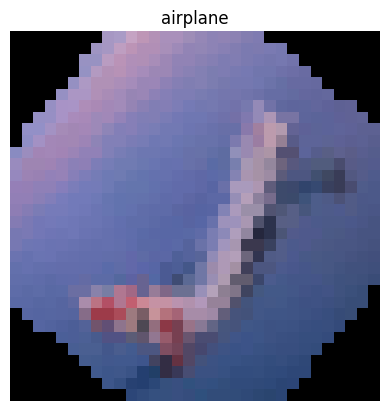

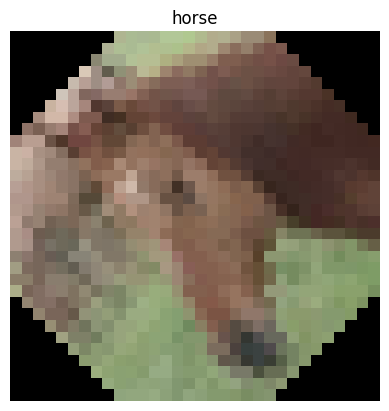

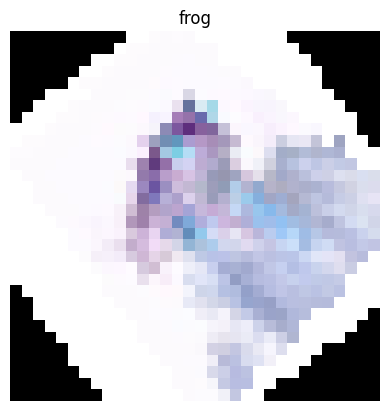

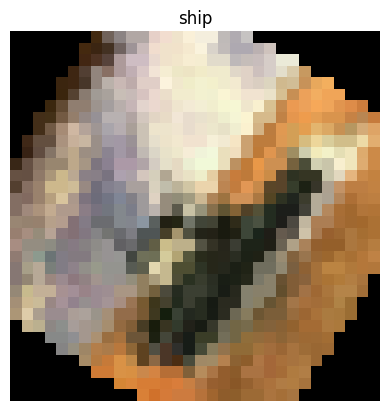

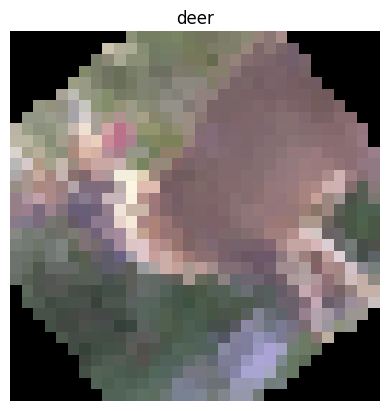

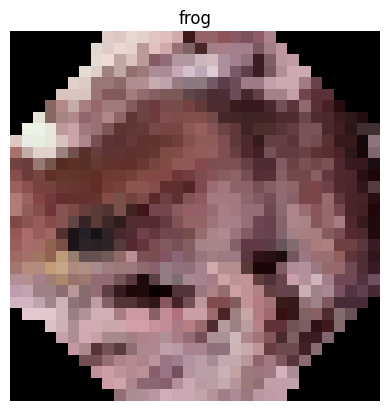

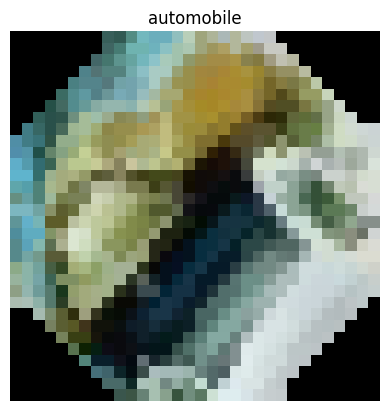

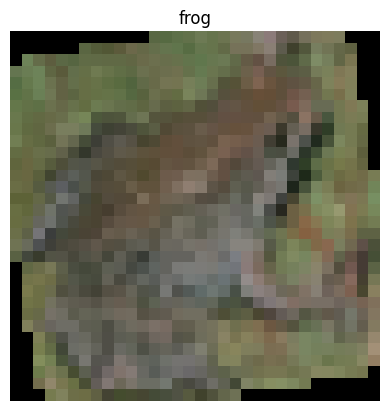

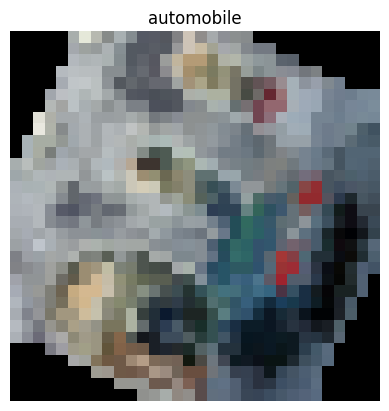

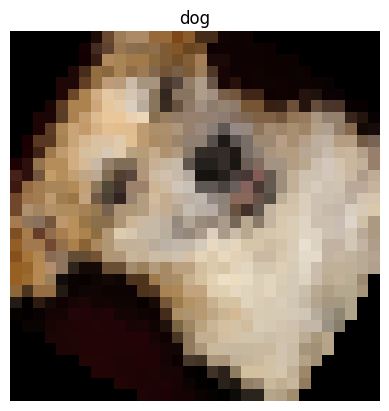

In [9]:
# Vamos visualizar algumas imagens
# Podemos ver também algumas transformações aplicadas

fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze().permute(1, 2, 0))
    plt.title(class_names[label])
    plt.axis(False)
    plt.show()

In [10]:
# Definindo tamanho de batches de processamento
BATCH_SIZE = 32

# Transforma os datasets batches
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Tamanho do dataloader de treino: {len(train_dataloader)} batches de {BATCH_SIZE}")
print(f"Tamanho do dataloader de teste: {len(test_dataloader)} batches de {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x795f20554d90>, <torch.utils.data.dataloader.DataLoader object at 0x795f20632d90>)
Tamanho do dataloader de treino: 1563 batches de 32
Tamanho do dataloader de teste: 313 batches de 32


In [11]:
# Veja dentro do dataloader de treino
# agora temo [batches, canais de cores, altura, largura]
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

Image size: torch.Size([3, 32, 32])
Label: 1, label size: torch.Size([])


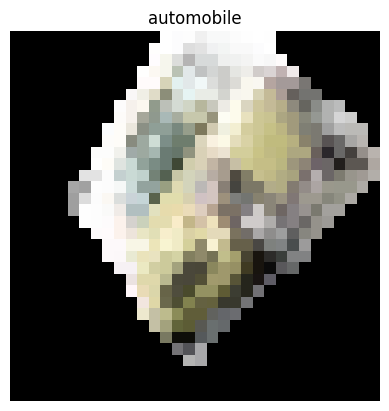

In [12]:
# Mostrando um mais exemplo
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze().permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")
plt.show()

## Criando o modelo base para teste - Model 0

In [13]:
# Model 0


class CIFAR10ModelV0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 2, 1, 0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 2, 1, 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 36,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

Estamos usando super().__init__() dentro da sua classe CIFAR10ModelV0 para chamar o construtor da classe pai, que nesse caso é nn.Module — a base de todos os modelos em PyTorch.


### ✅ Por que usar super().__init__()?
Inicializa o comportamento interno do PyTorch corretamente:
   
*  Isso configura o modelo para funcionar com .parameters(), .to(device), .eval(), .train() e backpropagation automática.
* Sem isso, o PyTorch não sabe que sua classe é um módulo com parâmetros treináveis.

Evita erros e perda de funcionalidades:


*   Se você não chamar super(), métodos essenciais do nn.Module não serão ativados, como o registro de submódulos (self.conv_block_1, etc.), e o modelo não funcionará corretamente em treinamento ou avaliação.
*   É a forma correta e segura de estender uma classe base em Python (herança).


In [14]:
# Modelo com os parâmetros de entrada
model_0 = CIFAR10ModelV0(input_shape=3, # RBG
    hidden_units=10, # quantas unidades na camada oculta
    output_shape=len(class_names) # output = um para cada classe (10)
).to(device)

model_0

CIFAR10ModelV0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=360, out_features=10, bias=True)
  )
)

In [15]:
# Função de perda e otimizador
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [16]:
# Função para medir o tempo de treino
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """
    Returns difference between the start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on.
        Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [17]:
# instala métrica de acurácia

!pip install torchmetrics
from torchmetrics.classification import Accuracy
import torch

accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_names)).to(device)


In [18]:
# Funções de treino e teste

def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device):
    model.train()
    model.to(device)
    train_loss = 0

    accuracy_fn.reset()  # Zera o estado interno da métrica

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)

        # Forward
        y_pred = model(X)

        # Loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Atualiza a acurácia
        accuracy_fn.update(y_pred, y)

    train_acc = accuracy_fn.compute().item() * 100  # Retorna acurácia acumulada
    train_loss /= len(data_loader)

    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%\n")



def test_step(data_loader, model, loss_fn, accuracy_fn, device):
    model.eval()
    model.to(device)
    test_loss = 0

    accuracy_fn.reset()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            test_loss += loss_fn(y_pred, y).item()
            accuracy_fn.update(y_pred, y)

    test_acc = accuracy_fn.compute().item() * 100
    test_loss /= len(data_loader)

    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")



In [19]:
# Medir o tempo
from tqdm.auto import tqdm
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n{50 * '-'}")
    train_step(data_loader=train_dataloader,
        model=model_0,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_0,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_on_gpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
--------------------------------------------------
Train loss: 2.30293 | Train accuracy: 10.07%

Test loss: 2.30256 | Test accuracy: 10.00%

Epoch: 1
--------------------------------------------------
Train loss: 2.30267 | Train accuracy: 9.92%

Test loss: 2.30247 | Test accuracy: 10.01%

Epoch: 2
--------------------------------------------------
Train loss: 2.30247 | Train accuracy: 10.41%

Test loss: 2.30194 | Test accuracy: 10.00%

Epoch: 3
--------------------------------------------------
Train loss: 2.30145 | Train accuracy: 10.69%

Test loss: 2.29834 | Test accuracy: 14.03%

Epoch: 4
--------------------------------------------------
Train loss: 2.28034 | Train accuracy: 14.74%

Test loss: 2.17062 | Test accuracy: 21.47%

Epoch: 5
--------------------------------------------------
Train loss: 2.21920 | Train accuracy: 19.27%

Test loss: 2.11103 | Test accuracy: 23.62%

Epoch: 6
--------------------------------------------------
Train loss: 2.19330 | Train accuracy: 21.

### CNN Model 0 teve uma performance ruim, vamos tentar com Transfer Learning

Usando a arquitetura do [MobileNet_V3_Large](https://arxiv.org/abs/1905.02244).

Veja a documentação: https://pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v3_large.html#torchvision.models.MobileNet_V3_Large_Weights

In [20]:
# Pesos do modelo
weights = torchvision.models.MobileNet_V3_Large_Weights.DEFAULT
weights

MobileNet_V3_Large_Weights.IMAGENET1K_V2

In [21]:
# Transforma os pesos
mobile_transforms = weights.transforms()
mobile_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [22]:
BATCH_SIZE = 32

# Dados com os novos transforms
train_data = CIFAR10(root="data",
                     download=True,
                     train=True,
                     transform=transforms.Compose([
                          transforms.ToTensor(),
                          mobile_transforms]))

test_data = CIFAR10(root="data",
                    download=True,
                    train=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        mobile_transforms]))


# Dataloaders
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [23]:
# Sumário
model_1 = torchvision.models.mobilenet_v3_large(weights=weights).to(device)

summary(model=model_1,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 59.8MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MobileNetV3 (MobileNetV3)                                    [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 960, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 16, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 16, 112, 112]   432                  True
│    │    └─BatchNorm2d (1)                                  [32, 16, 112, 112]   [32, 16, 112, 112]   32                   True
│    │    └─Hardswish (2)                                    [32, 16, 112, 112]   [32, 16, 112, 112]   --                   --
│    └─InvertedResidual (1)                                  [32, 16, 112, 112]   [32, 16, 112

In [24]:
# Vamos congelar os parâmetros para treinar somente a camda de classificação
for param in model_1.parameters():
    param.requires_grad = False

In [25]:
# Recriando a camada de classificação
model_1.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features=960,
                    out_features=len(class_names),
                    bias=True)).to(device)

In [26]:
# Novo sumário
summary(model=model_1,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MobileNetV3 (MobileNetV3)                                    [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 960, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 16, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 16, 112, 112]   (432)                False
│    │    └─BatchNorm2d (1)                                  [32, 16, 112, 112]   [32, 16, 112, 112]   (32)                 False
│    │    └─Hardswish (2)                                    [32, 16, 112, 112]   [32, 16, 112, 112]   --                   --
│    └─InvertedResidual (1)                                  [32, 16, 112, 112]   [32, 

In [27]:
# Define função de perda e otimizador
loss_fn_m1 = torch.nn.CrossEntropyLoss()
optimizer_m1 = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [28]:
# Medir tempo
from tqdm.auto import tqdm
from timeit import default_timer as timer

# Início da medição de tempo
train_time_start_on_gpu = timer()

# Número de épocas
epochs = 10

# Loop de treino
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n{30 * '-'}")

    train_step(
        data_loader=train_dataloader,
        model=model_1,
        loss_fn=loss_fn_m1,
        optimizer=optimizer_m1,
        accuracy_fn=accuracy_fn,
        device=device
    )

    test_step(
        data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn_m1,
        accuracy_fn=accuracy_fn,
        device=device
    )

# Fim da medição de tempo
train_time_end_on_gpu = timer()

total_train_time_model_1 = print_train_time(
    start=train_time_start_on_gpu,
    end=train_time_end_on_gpu,
    device=device
)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
------------------------------
Train loss: 0.82536 | Train accuracy: 71.78%

Test loss: 0.65837 | Test accuracy: 76.98%

Epoch: 1
------------------------------
Train loss: 0.69458 | Train accuracy: 75.74%

Test loss: 0.63300 | Test accuracy: 77.83%

Epoch: 2
------------------------------
Train loss: 0.65775 | Train accuracy: 77.11%

Test loss: 0.64068 | Test accuracy: 77.89%

Epoch: 3
------------------------------
Train loss: 0.63918 | Train accuracy: 77.71%

Test loss: 0.65833 | Test accuracy: 77.00%

Epoch: 4
------------------------------
Train loss: 0.62788 | Train accuracy: 78.09%

Test loss: 0.61300 | Test accuracy: 78.35%

Epoch: 5
------------------------------
Train loss: 0.61887 | Train accuracy: 78.42%

Test loss: 0.65261 | Test accuracy: 77.20%

Epoch: 6
------------------------------
Train loss: 0.61423 | Train accuracy: 78.57%

Test loss: 0.65279 | Test accuracy: 77.59%

Epoch: 7
------------------------------
Train loss: 0.61254 | Train accuracy: 78.52%

Test

In [30]:
# Salvando o modelo
from pathlib import Path

# Cria caminhos para salvar o modelo
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True
)

MODEL_NAME = "cifar10_ccn_transfer_learning_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Salvando model 1: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # salva state_dict(), parâmetros aprendidos
           f=MODEL_SAVE_PATH)

Salvando model 1: models/cifar10_ccn_transfer_learning_model.pth


# Agora que temos o modelo salvo, vamos classificar algumas imagens!

In [39]:
# 1. Upload de imagem
from google.colab import files
from PIL import Image
import torchvision.transforms as transforms

uploaded = files.upload()


Saving 360_F_250080568_QvCaYVy1NWJAVGeXdwa9YCKRtFLWITnZ.webp to 360_F_250080568_QvCaYVy1NWJAVGeXdwa9YCKRtFLWITnZ.webp


In [40]:
# 2. Carregar imagem e aplicar transformações compatíveis com MobileNetV3
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # MobileNet espera 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # valores padrão do ImageNet
                         std=[0.229, 0.224, 0.225])
])

image_path = list(uploaded.keys())[0]  # Pega o nome da imagem enviada
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)  # shape: [1, 3, 224, 224]


In [41]:
# Fazer a previsão
with torch.inference_mode():
    pred_logits = model_1(input_tensor)
    pred_label = torch.argmax(pred_logits, dim=1).item()


In [42]:
# Mapear o índice da previsão para as classes
class_names = [
'airplane',
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck'
]

print(f"Predição: {class_names[pred_label]}")
image.show()


Predição: bird
